In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import numpy as np 
import pandas as pd 
import os

In [4]:
! pip install --quiet segmentation_models_pytorch
!pip install --quiet torchsummary

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch import nn
from torchsummary import summary
import torchvision

import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import Linknet
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import segmentation_models_pytorch.utils as smp_utils

In [6]:
DATA_ROOT = Path('/kaggle/input/makeup-lips-segmentation-28k-samples/set-lipstick-original/')
IMAGE_PATH = DATA_ROOT / '720p'
MASK_PATH = DATA_ROOT / 'mask'
DF_PATH = DATA_ROOT / 'list.csv'

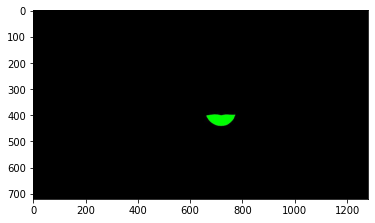

In [7]:
img = plt.imread(MASK_PATH / 'mask00000001.png')
plt.imshow(img);

In [8]:
df = pd.read_csv(DF_PATH)
df.shape

(28594, 9)

In [9]:
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [10]:
train_val_df, test_df = train_test_split(df, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

train_val_df.head(2)

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
10071,image00010072.jpg,1280,720,Lips,565,336,655,398,mask00010072.png
8510,image00008511.jpg,1280,720,Lips,637,349,724,391,mask00008511.png


In [11]:
class LipsDataset(torch.utils.data.DataLoader):
    IMG = 'filename'
    MSK = 'mask'
    data_type = 'float32' #'uint8'
    
    def __init__(self, mask_path: Path, img_path: Path, 
                 df: pd.DataFrame, preprocessing=None):
        self.mask_path = mask_path
        self.img_path = img_path
        self.df = df
        self.preprocessing = preprocessing
        
        tqdm.pandas()
        print('Check if is sended imgage exist...')
        self.df[self.IMG] = self.df[self.IMG]\
            .progress_apply(lambda f: img_path / f if os.path.exists(img_path / f) else np.NaN)
        
        print('Check if is sended mask exist...')
        self.df[self.MSK] = self.df[self.MSK]\
            .progress_apply(lambda f: mask_path / f if os.path.exists(mask_path / f) else np.NaN)
        self.df.dropna(axis=0, inplace=True)
    
    def __len__(self):
        return len(self.df)
    
    def  __getitem__(self, indx):
        
        image = cv2.imread(str(self.df.iloc[indx][self.IMG]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))
     
        image = image.astype(self.data_type)
        
        mask = cv2.imread(str(self.df.iloc[indx][self.MSK]))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = cv2.resize(mask, (256, 256))
        mask = mask / 255
        mask = mask.astype(self.data_type)
 
        if self.preprocessing:
            image = self.preprocessing(image)
    
        else:
            image = image / 255.0
            
        return torchvision.transforms.ToTensor()(image.astype(self.data_type)),\
                torchvision.transforms.ToTensor()(mask.astype(self.data_type))


In [12]:
def img_show(**images) -> None:
    n = len(images)
    plt.figure(figsize=(14, 5))
    
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(name)
    plt.show()


In [13]:
transforms = smp.encoders.get_preprocessing_fn('resnet50', pretrained='imagenet')

In [14]:
train_dataset = LipsDataset(mask_path=MASK_PATH,
                            img_path=IMAGE_PATH, 
                            df=train_df,
                            preprocessing=transforms)
val_dataset = LipsDataset(mask_path=MASK_PATH,
                            img_path=IMAGE_PATH, 
                            df=val_df,
                            preprocessing=transforms)

test_dataset = LipsDataset(mask_path=MASK_PATH,
                            img_path=IMAGE_PATH, 
                            df=test_df,
                            preprocessing=transforms)

Check if is sended imgage exist...


100%|██████████| 17156/17156 [00:51<00:00, 330.30it/s]


Check if is sended mask exist...


100%|██████████| 17156/17156 [00:51<00:00, 332.51it/s]


Check if is sended imgage exist...


100%|██████████| 4289/4289 [00:12<00:00, 332.66it/s]


Check if is sended mask exist...


100%|██████████| 4289/4289 [00:12<00:00, 337.56it/s]


Check if is sended imgage exist...


100%|██████████| 7149/7149 [00:21<00:00, 331.17it/s]


Check if is sended mask exist...


100%|██████████| 7149/7149 [00:21<00:00, 331.92it/s]


15431


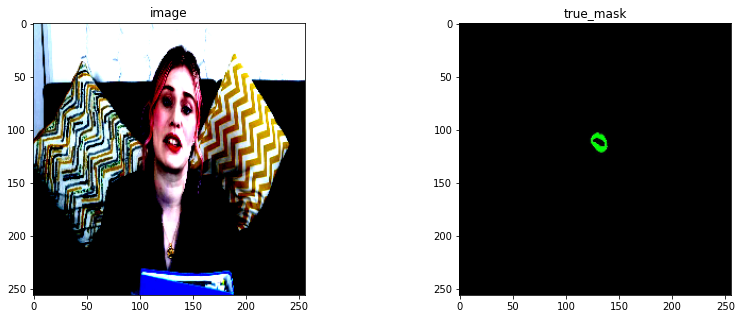

In [15]:
k = torch.randint(0,train_dataset.__len__(),(1,1)).item()
print(k)
image, mask = train_dataset[k]
img_show(image=image, true_mask=mask)

In [16]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=8, 
                                           shuffle=True, 
                                           num_workers=2)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=4, 
                                         num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=4, 
                                          num_workers=2)

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [18]:
model = Linknet(encoder_name='resnet50', 
               encoder_weights='imagenet', 
               classes=1,
               activation='sigmoid').to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [20]:
criterion = smp_utils.losses.DiceLoss()
metric = [smp_utils.metrics.IoU(),]

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.007)

In [21]:
train_epoch = smp_utils.train.TrainEpoch(model=model, 
                                         loss=criterion, 
                                         metrics=metric, 
                                         optimizer=optimizer, 
                                         device=device, 
                                         verbose=True)

valid_epoch = smp_utils.train.ValidEpoch(model=model, 
                                         loss=criterion, 
                                         metrics=metric, 
                                         device=device)

In [22]:
epochs = 1
max_score = 0
PATH_MODEL = './best_model.pth'
PATH_WEIGHTS = './best_weights.pth'
score_break_value = 0.9

for epoch in range(1,epochs+1):
    print(f'Current epoch - {epoch} from {epochs}')
    train_score = train_epoch.run(train_loader)
    valid_score = valid_epoch.run(val_loader)
    print(f'Next step.\n\n')
    
    if max_score < valid_score['iou_score']:
        max_score = valid_score['iou_score']
        torch.save(model.state_dict(), PATH_WEIGHTS)
        torch.save(model, PATH_MODEL)
        print('Model saved!')
        
    if max_score > score_break_value:
        break

Current epoch - 1 from 1
valid: 100%|██████████| 1070/1070 [02:04<00:00,  8.60it/s, dice_loss - 0.1587, iou_score - 0.7409]
Next step.


Model saved!


In [23]:
valid_epoch.run(test_loader)

valid: 100%|██████████| 1784/1784 [03:32<00:00,  8.39it/s, dice_loss - 0.1576, iou_score - 0.7434]


{'dice_loss': 0.157588381270122, 'iou_score': 0.7434308582774867}

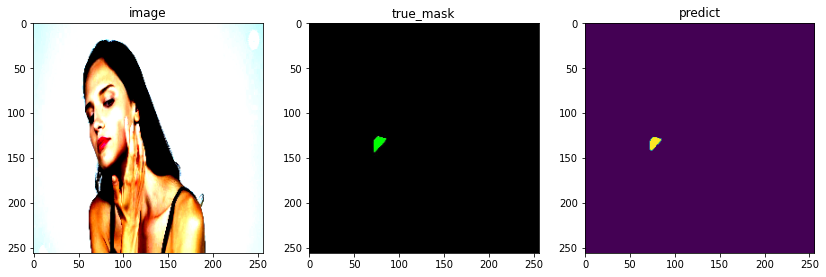

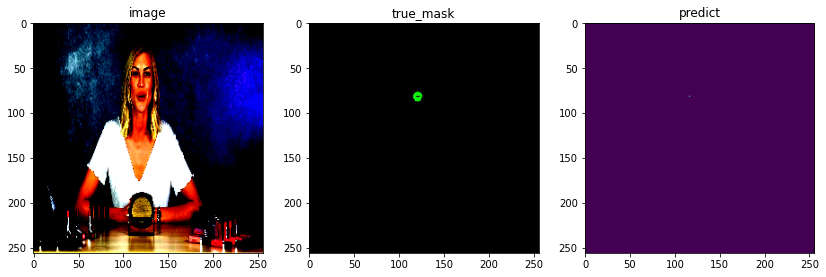

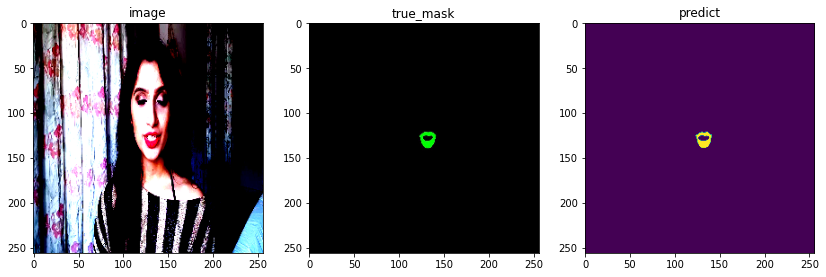

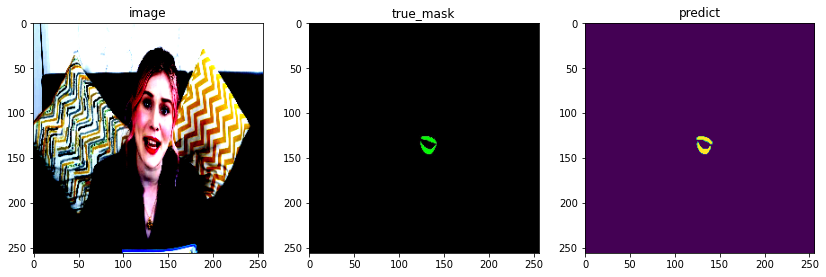

In [24]:
for image, mask in test_loader:
    for i in range(image.shape[0]):
        predict = model(image[i][None].to(device))[0, ...].cpu().detach()
        img_show(image=image[i], true_mask=mask[i], predict=predict)
    break